<a href="https://colab.research.google.com/github/alinemls/datasets/blob/main/Labeling_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de Bibliotecas

In [712]:
import numpy as np
import pandas as pd 
import seaborn as sns
import warnings
import cv2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from scipy.stats import randint
from mlxtend.plotting import plot_confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, cohen_kappa_score as kappa, confusion_matrix
from numpy.core.numeric import NaN
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.tree import export_graphviz
from google.colab.patches import cv2_imshow
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from mpl_toolkits.mplot3d import Axes3D

#from sklearn.tree import DecisionTreeClassifier as tree

warnings.filterwarnings("ignore")

# <><><><><><><><> Parâmetros <><><><><><><><>
p_normalizacao = 0  # 0(não normalizado), 1(desvio padrão), 2(escala 0 a 1)

t_discre = "uniform"
#‘uniform’: All bins in each feature have identical widths.
#‘quantile’: All bins in each feature have the same number of points.
#‘kmeans’: Values in each bin have the same nearest center of a 1D k-means cluster.

v_variation = 0.15

num_grupos = 3   

qtd_faixas = 5      # 0(automático) 

n_base = "iris"

#t_sel_att = "Regressao MLP"
# Regressao MLP
# Classificador MLP
# Mutual Info

qtd_teste = 0.3 # Porcentagem de dados para teste no seletor de atributos supervisionado

##Preparação e Carregamento das bases

In [713]:
scaler = StandardScaler()
trans = MinMaxScaler()

if n_base == "iris":
  bb = sns.load_dataset(n_base)

if n_base == 'seeds':
  bb = pd.read_csv("/content/drive/MyDrive/bases/seeds.csv",sep=",")

if n_base == 'glass':
  bb = pd.read_csv("/content/drive/MyDrive/bases/glass.csv",sep=",")

if n_base == 'wine':
  bb = pd.read_csv("/content/drive/MyDrive/bases/wine.csv",sep=",")

if n_base == 'cancer_mama':
  bb = pd.read_csv("/content/drive/MyDrive/bases/cancermama.csv",sep=",")
  bb = df.iloc[: , :-1]
  col_list = list(bb)
  columns_titles = ['id', 'fractal_dimension_worst', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'diagnosis']
  bb=bb.reindex(columns=columns_titles)


#pin = sns.load_dataset('penguins')
#iris.head()
#pin.head()
#pin.tail()
base_original = bb
print("=========> Base Original <=========\n",base_original)

#print("Descrição dos Dados:\n", base_original.describe())

# --> Remove nulls <--
data = base_original.dropna()
data = data.reset_index(drop = True)


if(num_grupos == 0): #<><><><><> Se a classe for o grupo <><><><><><>
  #print(data.columns[-1])
  #data[data.columns[-1]] = data[data.columns[-1]].map({0:'X'}, na_action='ignore')
  data[data.columns[-1]].replace(0, 'X', inplace = True)
  att_classe = data.iloc[: , -1]
  att_classe = att_classe.unique()
  qtd_classes = 0
  for item in att_classe:
    #print(item,i)
    #data.replace(to_replace=item, value=str(i))
    #data["species"].replace("setosa","kjkj", regex=True)
    data[data.columns[-1]].replace({item: qtd_classes}, inplace=True)
    qtd_classes = qtd_classes + 1
  data.columns = [*data.columns[:-1], 'grupo']
else:
  # --> Apagar Colunas classe <--
  if num_grupos > 0:
    #att_classe = "species"
    data = data.iloc[: , :-1] # Apaga o atributo classe (última coluna)


# Apaga o atributo ID
if 'ID' in data.columns:    
  data = data.drop(columns=["ID"]) 
if 'id' in data.columns: 
  data = data.drop(columns=["id"]) 

base_original = data

# --> Normalização <--
colunas = list(data.columns.values)
#print (colunas) 
n_normalizacao = "Sem Normalização"
if(p_normalizacao == 1):
  data = scaler.fit_transform(data)
  n_normalizacao = "Desvio Padrão"
if(p_normalizacao == 2):
  data = trans.fit_transform(data)
  n_normalizacao = "Escala 0-1"

data = pd.DataFrame(data, columns = colunas)

print("\n\n\n")
print("=========> Base Modificada <=========\n",data)
#print("Descrição dos Dados:\n", data.describe())


=========> Base Original <=========
      sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]




=========> Base Modificada <=========
      sepal_length  sepal_width  petal_length  petal_width
0         

In [714]:
bb.drop(labels=['Id'], axis=1, inplace=True, errors='ignore')

In [715]:
bb.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [716]:
# Agrupamento pela identificação completa da planta
#df.groupby('species').size()

##Agrupamento com o K-Means

In [717]:
if(num_grupos != 0): #<><><><><> Se a classe for o grupo <><><><><><>

  grupos = KMeans(num_grupos, random_state=0).fit(data)

  data = base_original

  data['grupo'] = grupos.labels_ # Cria uma coluna com o grupo de cada registro
  print("====> Base com Grupos <====\n\n",data)

print('Quantidade de Registros em cada Grupo:\n', data['grupo'].value_counts())

====> Base com Grupos <====

      sepal_length  sepal_width  petal_length  petal_width  grupo
0             5.1          3.5           1.4          0.2      1
1             4.9          3.0           1.4          0.2      1
2             4.7          3.2           1.3          0.2      1
3             4.6          3.1           1.5          0.2      1
4             5.0          3.6           1.4          0.2      1
..            ...          ...           ...          ...    ...
145           6.7          3.0           5.2          2.3      2
146           6.3          2.5           5.0          1.9      0
147           6.5          3.0           5.2          2.0      2
148           6.2          3.4           5.4          2.3      2
149           5.9          3.0           5.1          1.8      0

[150 rows x 5 columns]
Quantidade de Registros em cada Grupo:
 0    62
1    50
2    38
Name: grupo, dtype: int64


### Contrução do Modelo

dados:
     sepal_length sepal_width petal_length petal_width grupo
0            1.0         3.0          0.0         0.0     1
1            0.0         2.0          0.0         0.0     1
2            0.0         2.0          0.0         0.0     1
3            0.0         2.0          0.0         0.0     1
4            0.0         3.0          0.0         0.0     1
..           ...         ...          ...         ...   ...
145          3.0         2.0          3.0         4.0     2
146          2.0         1.0          3.0         3.0     0
147          3.0         2.0          3.0         3.0     2
148          2.0         2.0          3.0         4.0     2
149          2.0         2.0          3.0         3.0     0

[150 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sepal_length  150 non-null    object
 1   sepal_width  

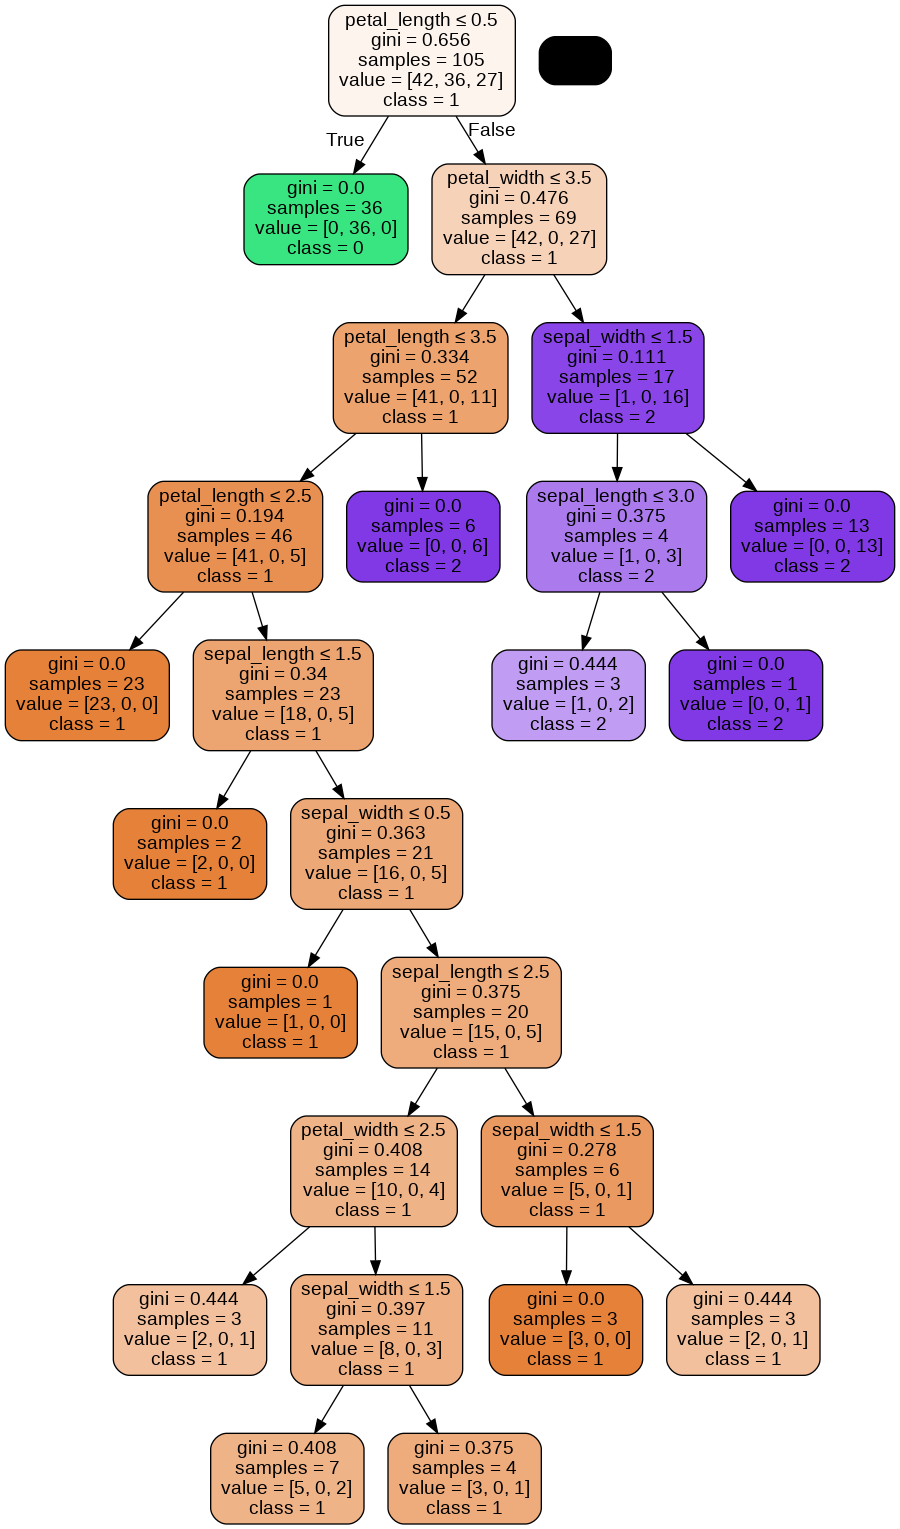

petal_length
0.5


In [718]:
# definir qual dataset será usado
#dataset_model = df.copy()

t_saida_arv = 1 # 1 --> Grafica  // 0 --> Texto

#print(data)

if qtd_faixas != 0:
#<><><><><> Discretização <><><><><>
  base = data.drop(columns=['grupo']) # Apaga o grupo
  col_grupo = data["grupo"]
  col_nomes = list(base.columns)

  enc = KBinsDiscretizer(n_bins=qtd_faixas, strategy=t_discre, encode="ordinal")
  base_d = enc.fit_transform(base)
  base_d = pd.DataFrame(base_d,columns=col_nomes) 
  base_d['grupo'] = col_grupo

  #base_d.apply(base_d.to_numeric, errors='ignore')
  base_d = base_d.astype(str)

  data = base_d
  print("dados:\n",data)
  print(data.info())

i_col = data.columns.size 

print(i_col-1)

treino, teste = train_test_split(data, test_size = qtd_teste)
Y_train = treino.iloc[:, i_col-1]
Y_teste = teste.iloc[:, i_col-1]
X_train = treino.drop(treino.columns[i_col-1], axis=1)
X_teste = teste.drop(teste.columns[i_col-1], axis=1)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_teste)

print("\nAcurácia da Árvore:",metrics.accuracy_score(Y_teste, y_pred), "\n")


feature_cols = X_teste.columns.to_list()
class_names = Y_teste.unique()

if(t_saida_arv == 1):
  
  acs = [str(x) for x in class_names]
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = feature_cols,class_names=acs)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
  graph.write_png(n_base+'.png')
  Image(graph.create_png())
  
  img = cv2.imread(n_base+'.png')
  cv2_imshow(img)

else:
  tree_rules = export_text(clf, feature_names = feature_cols) #print the result
  print(tree_rules)

print(feature_cols[clf.tree_.feature[0]])
print(clf.tree_.threshold[0])

In [719]:
X = data.drop(columns=['grupo']).values

In [720]:
X

array([['1.0', '3.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['0.0', '3.0', '0.0', '0.0'],
       ['1.0', '3.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['0.0', '1.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['1.0', '3.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['2.0', '4.0', '0.0', '0.0'],
       ['1.0', '4.0', '0.0', '0.0'],
       ['1.0', '3.0', '0.0', '0.0'],
       ['1.0', '3.0', '0.0', '0.0'],
       ['1.0', '3.0', '0.0', '0.0'],
       ['1.0', '3.0', '0.0', '0.0'],
       ['1.0', '2.0', '0.0', '0.0'],
       ['1.0', '3.0', '0.0', '0.0'],
       ['0.0', '3.0', '0.0', '0.0'],
       ['1.0', '2.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
       ['0.0', '2.0', '0.0', '0.0'],
 

In [721]:
# Transformação do atributo categórico em numérico
#le = preprocessing.LabelEncoder()
#le.fit(dataset_model.species)
#y = le.transform(dataset_model['species'].values)
#y

In [722]:
#unique, counts = np.unique(y, return_counts=True)
#dict(zip(unique, counts))

In [723]:
# Dividindo o dataset em subconjuntos de treino e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [724]:
#print('X_train =>',X_train.shape)
#print('X_test =>',X_test.shape)
#print('Y_train =>',y_train.shape)
#print('Y_test =>',y_test.shape)

In [725]:
# Modelo com DecisionTreeClassifier
#clf_dt = DecisionTreeClassifier(criterion='entropy')
#clf_dt = clf_dt.fit(X_train, y_train)
#y_predict_train = clf_dt.predict(X_train)
#y_predict_test = clf_dt.predict(X_test)

In [726]:
#X_test

In [727]:
#y_predict_all = clf_dt.predict(X)

In [728]:
#df['y'] = y_predict_all

In [729]:
#df.head(10)

In [730]:
#df.groupby('y').size()

In [731]:
# Checando a acurácia manualmente
print("Acurácia manual: %.2f" % np.mean(y_pred == Y_teste))

Acurácia manual: 0.91


In [732]:
# Avaliação
#accuracy = metrics.accuracy_score(y_test, y_predict_test)
#print("DecisionTree")
#print("Accuracy: %.2f" % (accuracy))
#print("Coeficiente de Kappa: %.2f" % (kappa(y_test, clf_dt.predict(X_test))) )
#print("F1 Score train: %.2f" % f1_score(y_train, y_predict_train))
#print("F1 Score test: %.2f" % f1_score(y_test, y_predict_test))

(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdbeb6ecad0>)

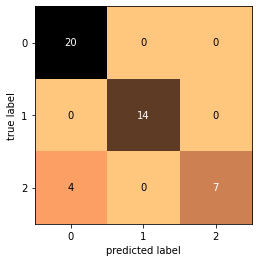

In [733]:
# Gerar a matrix de confusão NxN
conf_mat = confusion_matrix(Y_teste, y_pred)
plot_confusion_matrix(conf_mat,figsize=(12,4),cmap='copper_r')

In [734]:
#!pip install mlxtend --upgrade

In [735]:
# Gerar a árvore para exibição

#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
#tree.plot_tree(clf,
               #feature_names = bb.columns, 
               #class_names=['a','b'],
               #class_names=bb.grupo,
               #filled = True
               #)
#fig.savefig('tree.png')


In [736]:
!pip install graphviz

In [737]:
import graphviz

In [738]:
data.columns.drop('grupo')

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

In [739]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=data.columns.drop('grupo'),  
                      class_names=bb.species,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
#graph
graph.render(filename="iris", view=True, format='png')

'iris.png'

In [740]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'])
print(r)

|--- Petal_Length <= 0.50
|   |--- class: 1
|--- Petal_Length >  0.50
|   |--- Petal_Width <= 3.50
|   |   |--- Petal_Length <= 3.50
|   |   |   |--- Petal_Length <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- Petal_Length >  2.50
|   |   |   |   |--- Sepal_Length <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Sepal_Length >  1.50
|   |   |   |   |   |--- Sepal_Width <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Sepal_Width >  0.50
|   |   |   |   |   |   |--- Sepal_Length <= 2.50
|   |   |   |   |   |   |   |--- Petal_Width <= 2.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Petal_Width >  2.50
|   |   |   |   |   |   |   |   |--- Sepal_Width <= 1.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Sepal_Width >  1.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Sepal_Length >  2.50
|   |   |   |   |   |   |   |--- Sepal_Width <= 1

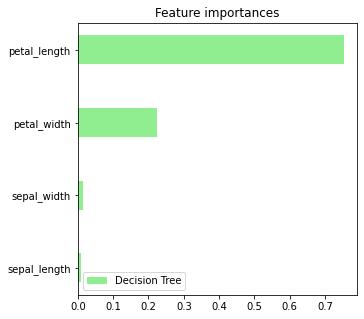

In [741]:
# Feature importances

feature_importance=pd.DataFrame({
    #'rfc':clf_rf.feature_importances_,
    'dt':clf.feature_importances_
},index=data.drop(columns=['grupo']).columns)
feature_importance.sort_values(by='dt',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(5,5))
#rfc_feature=ax.barh(index,feature_importance['rfc'],0.4,color='purple',label='Random Forest')
dt_feature=ax.barh(index+0.4,feature_importance['dt'],0.4,color='lightgreen',label='Decision Tree')
ax.set(yticks=index+0.4,yticklabels=feature_importance.index)
ax.set_title("Feature importances")
ax.legend()
plt.show()
